# 🇺🇬 A Machine Learning Approach to Accurate Import Valuation in Uganda

This notebook aims to build predictive models for import valuation using Uganda's customs data (2020–2024). Inaccurate manual methods contribute to revenue leakage, and we aim to use ML to bridge that gap. This aligns with the goals of URA’s Vision 2040 and digital transformation.

**Objectives**:
- Predict CIF values accurately using supervised ML models
- Compare ML vs traditional valuation methods
- Provide visual insights for operational integration

---


In [33]:
#importing the required libraries
# === Essential Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import warnings
import shap
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: "%.2f" % x)


LOADING THE DATA

In [34]:
# Load training and testing datasets
df_train = pd.read_csv("Uganda_imports_train.csv")
df_test = pd.read_csv("Uganda_imports_test.csv")

In [35]:
# Overview
print(df_train.shape)
print(df_test.shape)

(70734, 26)
(70734, 25)


In [36]:
df_train.head(5)

,HS_Code,Item_Description,Country_of_Origin,Port_of_Shipment,Quantity,Quantity_Unit,Net_Mass_kg,Gross_Mass_kg,FOB_Value_USD,Freight_USD,...,Mode_of_Transport,Year,Month,Invoice_Amount,Valuation_Method,Value_per_kg,Value_per_unit,FOB_per_kg,Freight_per_kg,Insurance_per_kg
0,30049099,Generic pharmaceutical products,China,Port Bell,482.42,kg,2220.29,2403.43,2352.84,220.04,...,Water,2021,11,9671924.57,Deductive Value Method (DVM),4356.15,20048.76,1.06,0.10,0.02
1,30049099,Generic pharmaceutical products,China,Entebbe Airport,131.97,liters,348.67,377.42,2084.10,169.47,...,Air,2022,11,8412978.38,Computed Value Method (CVM),24128.77,63749.17,5.98,0.49,0.05
2,15079090,Vegetable fats and oils,Germany,Entebbe Airport,113.44,pairs,449.93,487.04,2759.84,151.30,...,Air,2022,3,10672562.76,Transaction Value of Similar Goods (TVSG),23720.50,94081.12,6.13,0.34,0.12
3,10063010,Milled rice,India,Busia,230.52,units,808.09,874.73,2917.65,214.86,...,Land,2023,4,11692581.49,Computed Value Method (CVM),14469.41,50722.63,3.61,0.27,0.05
4,84089010,Industrial machinery parts,Saudi Arabia,Entebbe Airport,341.70,boxes,896.63,970.58,6971.39,366.85,...,Air,2021,6,26519078.57,Computed Value Method (CVM),29576.39,77609.24,7.78,0.41,0.15


In [37]:
df_test.head(5)

,HS_Code,Item_Description,Country_of_Origin,Port_of_Shipment,Quantity,Quantity_Unit,Net_Mass_kg,Gross_Mass_kg,FOB_Value_USD,Freight_USD,...,Mode_of_Transport,Year,Month,Invoice_Amount,Valuation_Method,Value_per_kg,Value_per_unit,FOB_per_kg,Freight_per_kg,Insurance_per_kg
0,30049099,Generic pharmaceutical products,China,Port Bell,482.42,kg,2220.29,2403.43,2352.84,220.04,...,Water,2021,11,9671924.57,Deductive Value Method (DVM),4356.15,20048.76,1.06,0.10,0.02
1,30049099,Generic pharmaceutical products,China,Entebbe Airport,131.97,liters,348.67,377.42,2084.10,169.47,...,Air,2022,11,8412978.38,Computed Value Method (CVM),24128.77,63749.17,5.98,0.49,0.05
2,15079090,Vegetable fats and oils,Germany,Entebbe Airport,113.44,pairs,449.93,487.04,2759.84,151.30,...,Air,2022,3,10672562.76,Transaction Value of Similar Goods (TVSG),23720.50,94081.12,6.13,0.34,0.12
3,10063010,Milled rice,India,Busia,230.52,units,808.09,874.73,2917.65,214.86,...,Land,2023,4,11692581.49,Computed Value Method (CVM),14469.41,50722.63,3.61,0.27,0.05
4,84089010,Industrial machinery parts,Saudi Arabia,Entebbe Airport,341.70,boxes,896.63,970.58,6971.39,366.85,...,Air,2021,6,26519078.57,Computed Value Method (CVM),29576.39,77609.24,7.78,0.41,0.15


In [38]:
df_train.columns

Index(['HS_Code', 'Item_Description', 'Country_of_Origin', 'Port_of_Shipment',
       'Quantity', 'Quantity_Unit', 'Net_Mass_kg', 'Gross_Mass_kg',
       'FOB_Value_USD', 'Freight_USD', 'Insurance_USD', 'CIF_Value_USD',
       'CIF_Value_UGX', 'Unit_Price_UGX', 'Tax_Rate', 'Currency_Code',
       'Mode_of_Transport', 'Year', 'Month', 'Invoice_Amount',
       'Valuation_Method', 'Value_per_kg', 'Value_per_unit', 'FOB_per_kg',
       'Freight_per_kg', 'Insurance_per_kg'],
      dtype='object')

In [39]:
df_test.columns

Index(['HS_Code', 'Item_Description', 'Country_of_Origin', 'Port_of_Shipment',
       'Quantity', 'Quantity_Unit', 'Net_Mass_kg', 'Gross_Mass_kg',
       'FOB_Value_USD', 'Freight_USD', 'Insurance_USD', 'CIF_Value_USD',
       'CIF_Value_UGX', 'Tax_Rate', 'Currency_Code', 'Mode_of_Transport',
       'Year', 'Month', 'Invoice_Amount', 'Valuation_Method', 'Value_per_kg',
       'Value_per_unit', 'FOB_per_kg', 'Freight_per_kg', 'Insurance_per_kg'],
      dtype='object')

### OBSERVATION
Although the train and test datasets are structurally consistent—with 24 features—there is a key omission in the test data: the target variable Unit_Price_UGX. This is an intentional and standard practice in supervised machine learning, ensuring that the model is evaluated on truly unseen data. The consistent feature set between both datasets supports model generalization, while the exclusion of the target from the test set prevents data leakage. However, it is critical to ensure that all preprocessing steps (e.g., encoding, scaling, and imputation) applied during training are identically replicated on the test data to maintain prediction accuracy and integrity.

In [40]:
# proceeding to work more with the training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70734 entries, 0 to 70733
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HS_Code            70734 non-null  int64  
 1   Item_Description   70734 non-null  object 
 2   Country_of_Origin  70734 non-null  object 
 3   Port_of_Shipment   70734 non-null  object 
 4   Quantity           70734 non-null  float64
 5   Quantity_Unit      70734 non-null  object 
 6   Net_Mass_kg        70734 non-null  float64
 7   Gross_Mass_kg      70734 non-null  float64
 8   FOB_Value_USD      70734 non-null  float64
 9   Freight_USD        70734 non-null  float64
 10  Insurance_USD      70734 non-null  float64
 11  CIF_Value_USD      70734 non-null  float64
 12  CIF_Value_UGX      70734 non-null  float64
 13  Unit_Price_UGX     70734 non-null  float64
 14  Tax_Rate           70734 non-null  float64
 15  Currency_Code      70734 non-null  object 
 16  Mode_of_Transport  707

Train Dataset Overview

The training dataset comprises 70,734 fully populated records across 26 columns, exhibiting no missing values—an ideal condition for robust modeling. The feature set includes a balanced mix of numerical (19 columns: 16 floats, 3 integers) and categorical (7 object-type) variables, which supports diverse predictive modeling techniques. The presence of rich transactional data—such as FOB_Value_USD, CIF_Value_UGX, and Invoice_Amount—alongside contextual descriptors like Country_of_Origin, Port_of_Shipment, and Valuation_Method, provides a strong foundation for capturing both quantitative and qualitative influences on the target variable Unit_Price_UGX. The absence of nulls reduces preprocessing overhead and points to a well-curated dataset, though proper encoding and scaling will still be required for the categorical and continuous variables, respectively, to ensure optimal model performance.

In [41]:
# checking for descriptive stats on the training dataset
df_train.describe()

,HS_Code,Quantity,Net_Mass_kg,Gross_Mass_kg,FOB_Value_USD,Freight_USD,Insurance_USD,CIF_Value_USD,CIF_Value_UGX,Unit_Price_UGX,Tax_Rate,Year,Month,Invoice_Amount,Value_per_kg,Value_per_unit,FOB_per_kg,Freight_per_kg,Insurance_per_kg
count,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00,70734.00
mean,41919932.31,316.51,725.91,785.78,4306.91,330.52,47.08,4685.70,17330989.04,151323.88,0.16,2022.00,6.53,17330989.04,104255.20,152333.30,25.92,1.98,0.29
std,29558572.64,306.91,746.19,807.74,1836.71,237.02,31.00,2006.42,7435593.62,163745.99,0.07,1.41,3.45,7435593.62,200483.72,162888.30,49.83,4.48,0.63
min,10063010.00,5.25,2.42,2.61,43.47,1.77,0.25,49.93,185312.63,62.20,0.05,2020.00,1.00,185312.63,248.31,692.50,0.06,0.00,0.00
25%,15079090.00,77.90,151.88,164.41,2942.24,138.34,22.06,3200.72,11828281.51,31865.05,0.10,2021.00,4.00,11828281.51,14080.66,32822.00,3.49,0.22,0.03
50%,30049099.00,183.18,391.19,423.45,4203.45,281.02,40.76,4566.11,16853980.07,86718.70,0.18,2022.00,7.00,16853980.07,40541.90,86718.70,10.08,0.63,0.09
75%,84089010.00,467.95,1099.81,1190.51,5548.97,474.60,65.84,6037.45,22333531.29,214177.60,0.20,2023.00,10.00,22333531.29,109842.08,214112.97,27.31,1.91,0.28
max,87032319.00,938.51,2220.29,2403.43,9679.16,1011.14,135.63,10532.16,38961476.57,729221.44,0.25,2024.00,12.00,38961476.57,3559753.60,729221.44,882.13,115.51,14.58


## Key Statistical Observations from Train Dataset
Data Distribution: Most numerical features show a right-skewed distribution, as evidenced by their means being higher than the medians (e.g., Unit_Price_UGX, Value_per_kg, FOB_per_kg). This suggests the presence of high-value outliers, which could influence model behavior and may require log transformation or robust scaling.

Target Variable (Unit_Price_UGX): The unit price in UGX ranges from 62.20 to 729,221.44, with a high standard deviation of 163,745.99, indicating substantial variance. Its median value (86,718.70) is significantly lower than the mean (151,323.88), confirming skewness.

Freight and Insurance Costs: Both Freight_USD and Insurance_USD exhibit wide variability, with maximum values exceeding 1,000 USD and 135 USD respectively. However, Freight_per_kg and Insurance_per_kg show that some shipments had minimal to no costs per kilogram, suggesting variable valuation or subsidization.

Mass and Quantity: The Gross_Mass_kg and Net_Mass_kg are highly correlated, with average values of 786 kg and 726 kg respectively. The mass-based price features (FOB_per_kg, Value_per_kg) are also spread out significantly, which may affect model sensitivity to weight-based features.

Time Span: The data spans from 2020 to 2024, which may allow for trend or seasonality analysis using the Year and Month columns. This temporal information can be used to detect policy changes, macroeconomic shifts, or demand cycles.

Taxes and Valuation: The Tax_Rate has a relatively small standard deviation and ranges between 5% and 25%, indicating tiered tax policies. This could be an influential categorical feature when paired with Valuation_Method.

## DATA SANITY CHECKS

CHECKING FOR MISSING VALUES

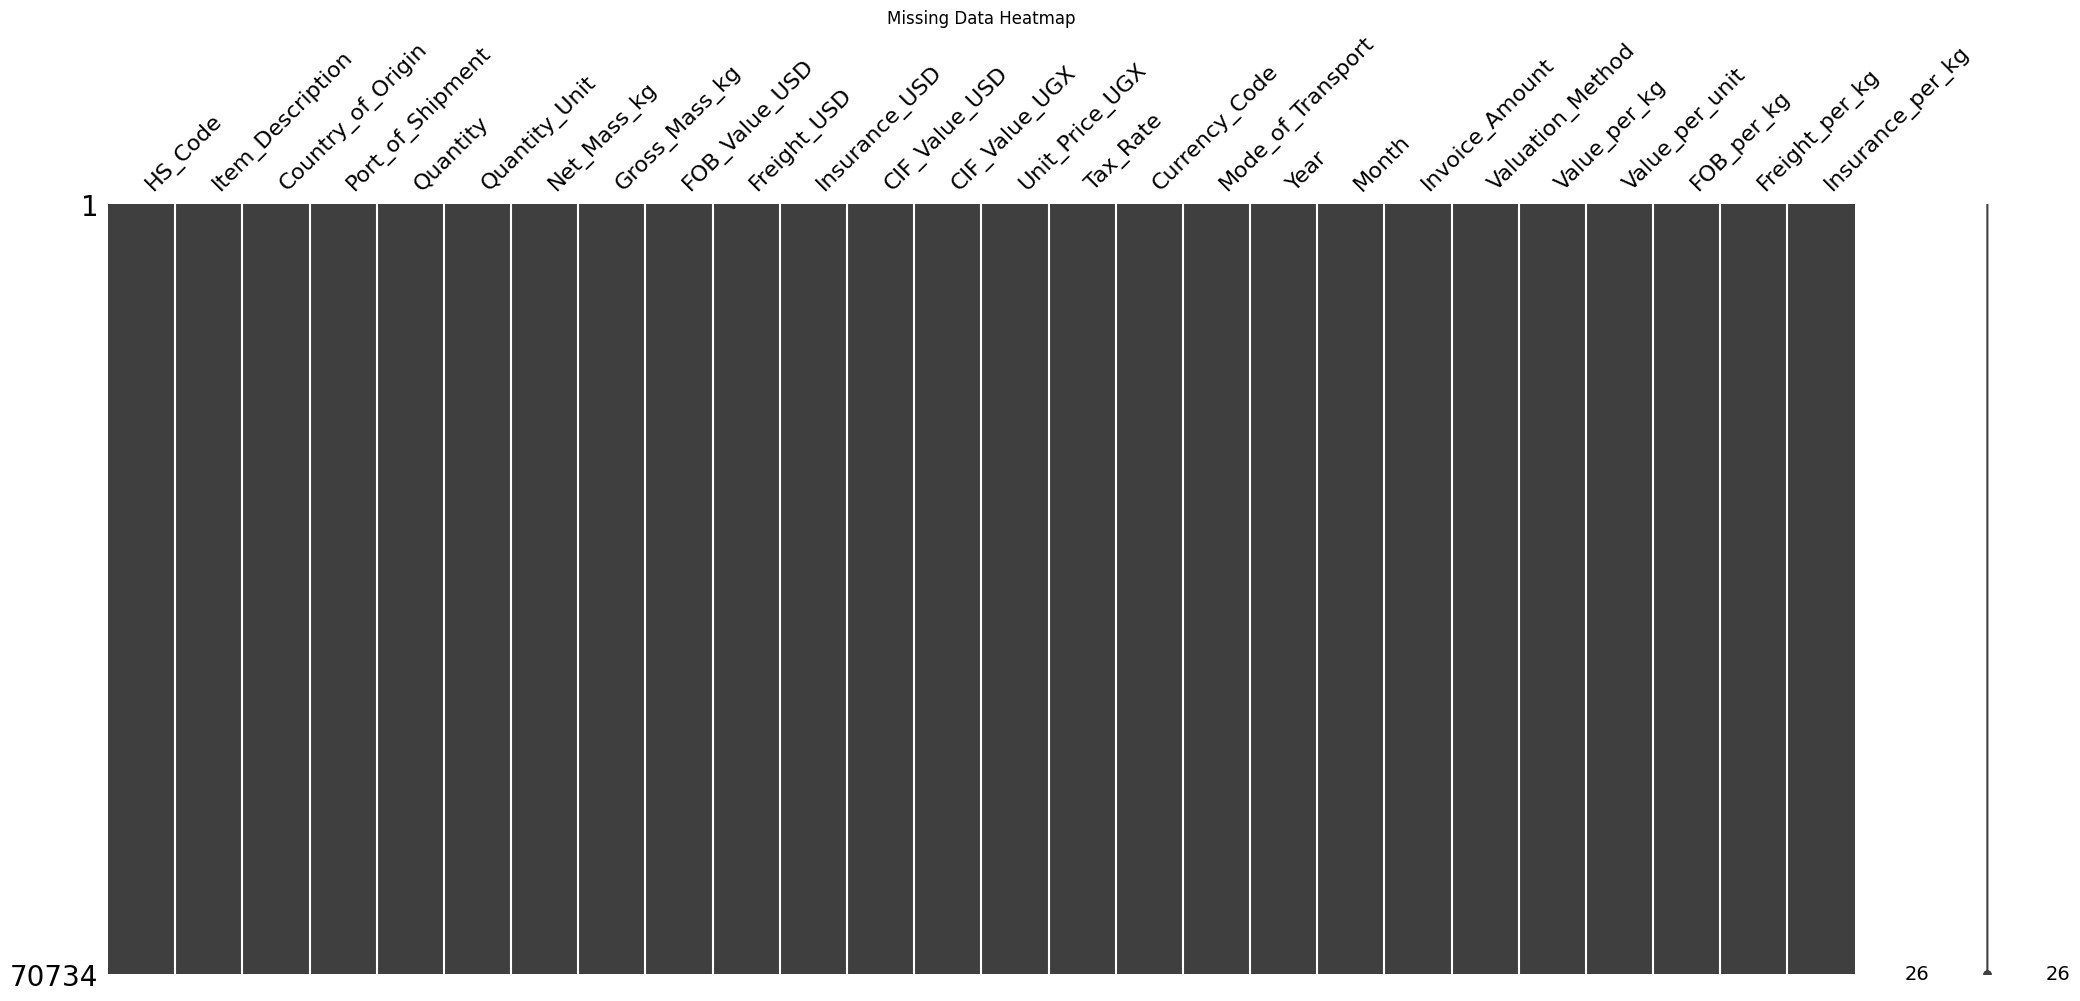

In [42]:
import missingno as msno
msno.matrix(df_train)
plt.title("Missing Data Heatmap")
plt.show()


### Missing Data Analysis
The missingno heatmap shows that there is no missing data in the training dataset. Each column is fully populated across all 70,734 records, which is visually confirmed by the solid vertical bars without any white gaps (which would indicate null values). This clean state of data ensures that no imputation, deletion, or preprocessing for missing values is necessary, streamlining the modeling pipeline and reducing potential bias or information loss during handling of nulls

## Exploratory Data Analysis

We conduct descriptive, univariate, and bivariate analyses to understand key factors influencing CIF valuation such as `Unit_Price`, `Country_of_Origin`, and `Port_of_Shipment`.

We use:
- Histograms, KDEs for distribution
- Q-Q plots for normality
- Correlation matrices
- Boxplots for category-value insights


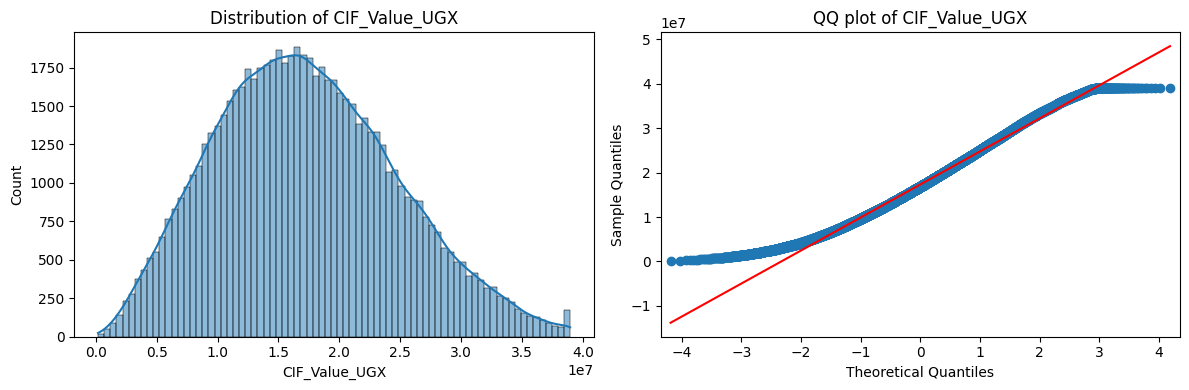

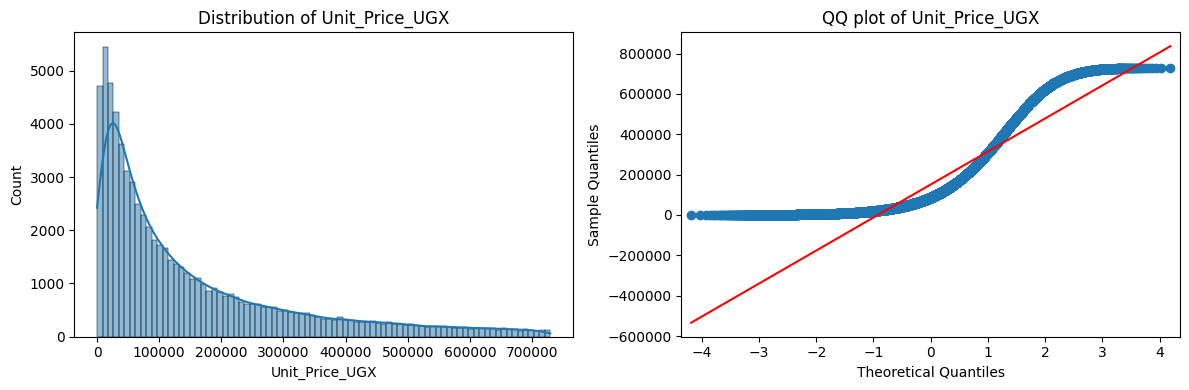

In [43]:
for col in ['CIF_Value_UGX', 'Unit_Price_UGX']:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_train[col], kde=True, ax=ax[0])
    ax[0].set_title(f'Distribution of {col}')
    
    sm.qqplot(df_train[col], line='s', ax=ax[1])
    ax[1].set_title(f'QQ plot of {col}')
    plt.tight_layout()
    plt.show()


### Distribution and Normality of CIF_Value_UGX
Why CIF_Value_UGX was plotted:
Since the task is to predict the Unit Price (UGX), CIF_Value_UGX is a critical predictor because it encapsulates the total cost of the import (Cost + Insurance + Freight) — a foundational component in pricing. Analyzing its distribution helps assess feature behavior and guides preprocessing steps for modeling.

Observations:
Histogram (left plot):

Shows a right-skewed but unimodal distribution. This indicates that most CIF values are concentrated around a central range, but some outliers exist (high-cost items).

QQ Plot (right plot):

Shows deviation from normality, especially in the tails.Confirms heavy-tailed behavior, which is typical in financial or transactional data.

### Distribution and Normality of Unit_Price_UGX (Target Variable)
Why Unit_Price_UGX was plotted:
Since the task is to predict Unit Price (UGX), understanding its distribution is essential. This helps guide model choice, loss function design, and preprocessing like transformations.

Key Observations:
Histogram (left plot):

Strongly right-skewed (positively skewed). Majority of unit prices are concentrated at the lower end, with a long tail of high-value items.

QQ Plot (right plot): Clear departure from the normal line, especially in the tails. confirms that the data is not normally distributed, which can affect models sensitive to scale and distribution.

## Univariate Analysis of Unit_Price_UGX
Descriptive Statistics + Histogram + KDE

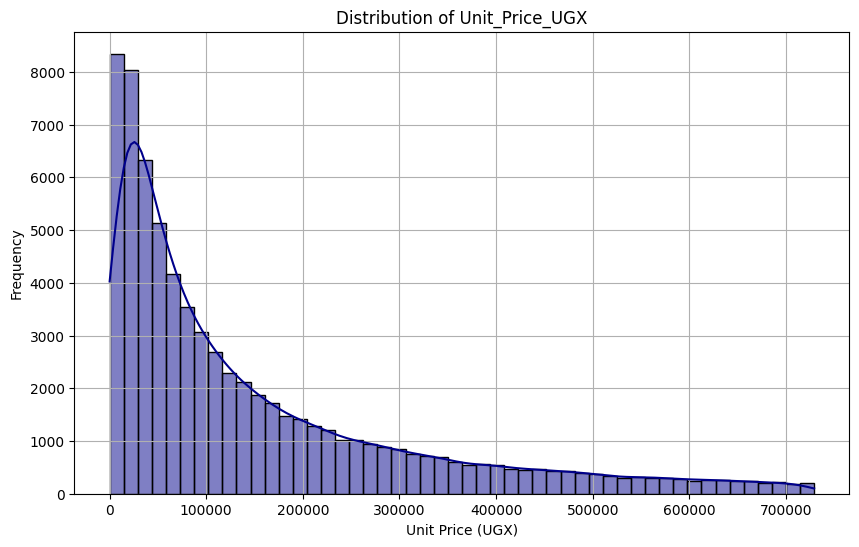

In [44]:
# Summary stats
unit_price = df_train["Unit_Price_UGX"]
unit_price.describe()

# Plotting histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(unit_price, bins=50, kde=True, color='darkblue')
plt.title("Distribution of Unit_Price_UGX")
plt.xlabel("Unit Price (UGX)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [45]:
from scipy.stats import skew, kurtosis

print("Skewness:", skew(unit_price))
print("Kurtosis:", kurtosis(unit_price))


Skewness: 1.5186547389262615
Kurtosis: 1.6540909341526548


### Skewness = 1.52 (positive)
A skewness of 1.52 indicates a right-skewed distribution (positively skewed).

This statistically means: Most data values are concentrated on the left (lower prices), with a long tail extending to the right (high prices).The distribution is not symmetric around the mean.

Why it matters: Models that assume normality (like linear regression or neural networks without transformations) may perform poorly without addressing this skewness. We shall apply a log transformation to reduce skewness and bring the distribution closer to normality.

Bivariate Analysis with Categorical Features
Boxplot by Country of Origin

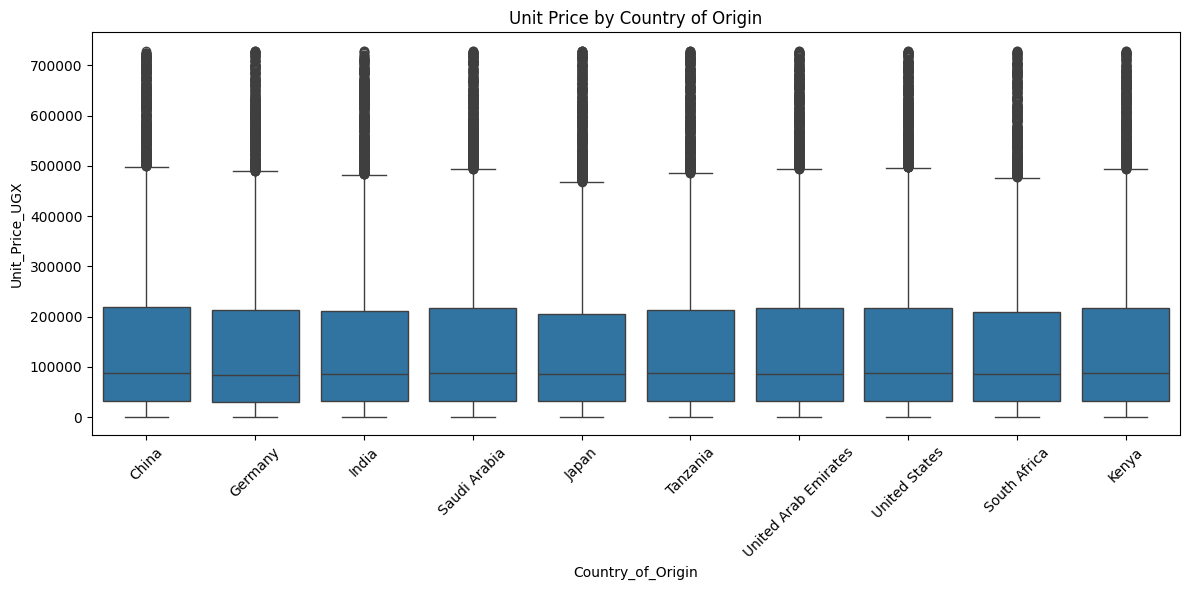

In [46]:
plt.figure(figsize=(12, 6))
top_countries = df_train['Country_of_Origin'].value_counts().nlargest(10).index
sns.boxplot(data=df_train[df_train['Country_of_Origin'].isin(top_countries)],
            x='Country_of_Origin', y='Unit_Price_UGX')
plt.xticks(rotation=45)
plt.title("Unit Price by Country of Origin")
plt.tight_layout()
plt.show()


ANOVA – Does Unit Price Differ by Country?

In [47]:
from scipy.stats import f_oneway

# Run ANOVA on top countries
groups = [df_train[df_train['Country_of_Origin'] == country]['Unit_Price_UGX']
          for country in top_countries]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic = {f_stat:.3f}, p = {p_value:.3e}")


ANOVA F-statistic = 1.189, p = 2.966e-01


CORRELATION ANALYSIS

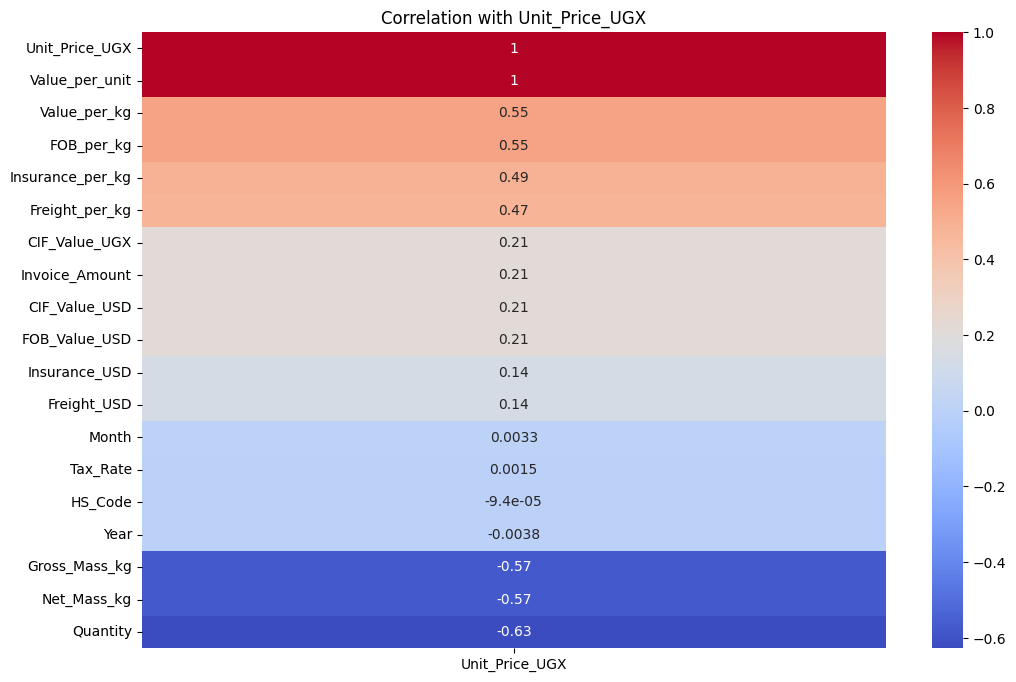

In [48]:
plt.figure(figsize=(12, 8))
corr_matrix = df_train.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix[['Unit_Price_UGX']].sort_values(by='Unit_Price_UGX', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation with Unit_Price_UGX")
plt.show()


Statistical Interpretation of Correlation with Unit_Price_UGX
Correlation values close to +1 or -1 indicate strong linear relationships; values near 0 suggest weak or no linear relationship. Here's what your heatmap tells us:

| **Feature**         | **Corr** | **Interpretation**                                                                 |
|---------------------|----------|-------------------------------------------------------------------------------------|
| `Value_per_unit`    | 1.00     | Perfect correlation – possibly a derived field from unit price. May cause leakage. |
| `Value_per_kg`      | 0.55     | Strong relationship; economically logical proxy for unit value in trade.           |
| `FOB_per_kg`        | 0.55     | Strong – origin cost aligns well with unit value. Reflects base product pricing.   |
| `Insurance_per_kg`  | 0.49     | Moderate-high – higher insurance often implies more valuable goods.                |
| `Freight_per_kg`    | 0.47     | Moderate – higher for smaller, higher-value items.                                 |

Implication: Features like *_per_kg ratios are meaningful economic indicators for unit pricing. Keep them in the model.

| **Feature**             | **Corr** | **Interpretation**                                                                 |
|-------------------------|----------|-------------------------------------------------------------------------------------|
| `CIF_Value_UGX`         | 0.21     | CIF = total value, but not standardized to quantity. Still relevant.               |
| `Invoice_Amount`        | 0.21     | Weak-moderate – might be inflated or noisy. Secondary relevance.                   |
| `CIF_Value_USD`         | ~0.21    | Total values less useful without normalization – already captured by per-kg ratios.|
| `FOB_Value_USD`         | ~0.21    | Same as above – normalization improves interpretability.                           |
| `Freight_USD`           | ~0.21    | Total freight is less informative than per-unit or per-kg freight.                 |

### STRONG NEGATIVE CORRELATIONS

| Feature        | Corr     | Insight |
|----------------|----------|---------|
| **Quantity**   | **-0.63**| Strong inverse relationship. High quantities often imply wholesale pricing, lowering unit price. |
| **Net_Mass_kg**| **-0.57**| Heavier shipments tend to have lower unit prices (bulk goods: cement, wheat, etc.). |
| **Gross_Mass_kg**| -0.57  | Similar effect; consistent with trade economics.

Average unit price per country

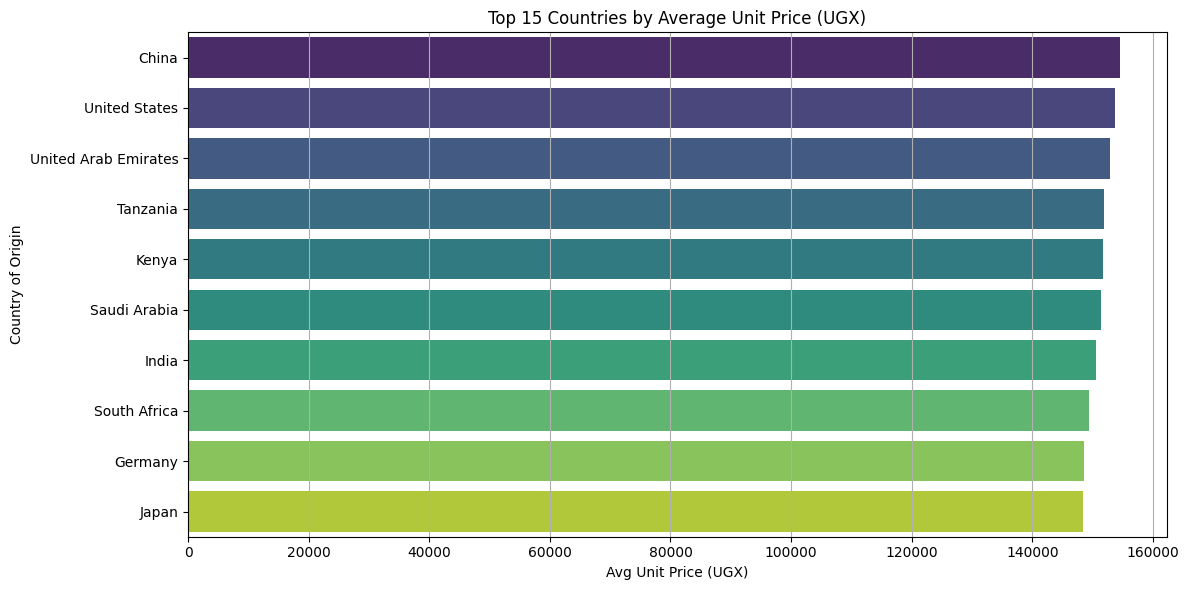

In [52]:
# Get top 15 countries by average unit price
country_avg = df_train.groupby("Country_of_Origin")["Unit_Price_UGX"].mean().sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=country_avg.values, y=country_avg.index, palette="viridis")
plt.title("Top 15 Countries by Average Unit Price (UGX)")
plt.xlabel("Avg Unit Price (UGX)")
plt.ylabel("Country of Origin")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


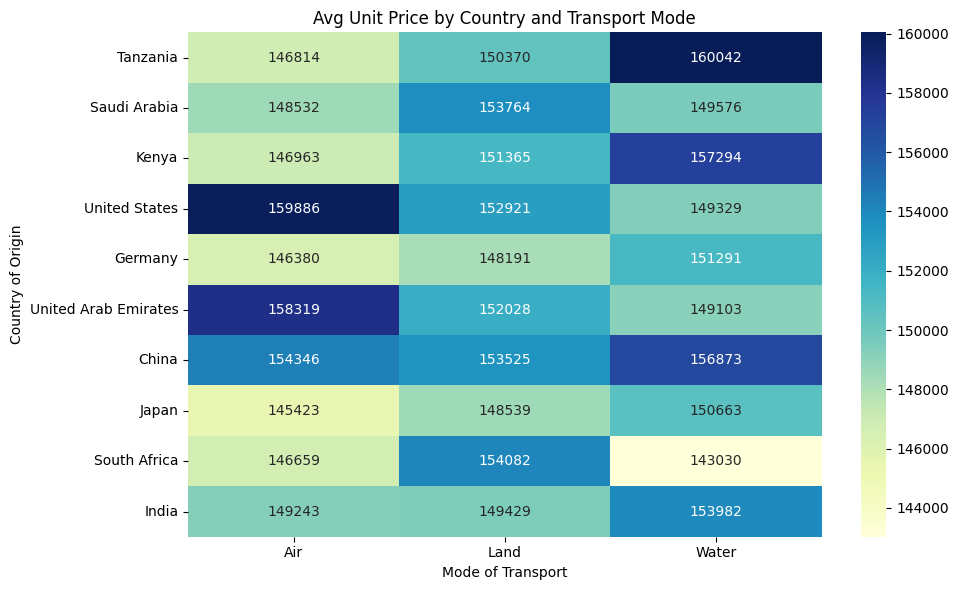

In [53]:
# Pivot for heatmap
pivot_table = df_train.pivot_table(
    values="Unit_Price_UGX",
    index="Country_of_Origin",
    columns="Mode_of_Transport",
    aggfunc="mean"
).fillna(0)

# Select top countries
top_countries = df_train['Country_of_Origin'].value_counts().nlargest(10).index
filtered = pivot_table.loc[top_countries]

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(filtered, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Avg Unit Price by Country and Transport Mode")
plt.ylabel("Country of Origin")
plt.xlabel("Mode of Transport")
plt.tight_layout()
plt.show()


Notably, Tanzania shows the highest unit price when using water transport (160,042), which is the overall peak value in the dataset, followed closely by the United States via air transport (159,886) and United Arab Emirates also via air (158,319). This suggests that air transport is often used for high-value goods, particularly from countries like the U.S. and UAE. Conversely, South Africa exhibits the lowest unit price for water transport (143,030), indicating that goods shipped by water from there are either lower in value or transported in bulk.

Kenya and China show elevated prices through water transport as well, suggesting a similar use case of shipping higher-value products through this mode. In contrast, countries like Germany, Japan, and India show relatively stable unit prices across transport modes, with minor fluctuations, implying a more consistent value per shipment regardless of logistics. Land transport generally shows less variability and slightly lower average unit prices, possibly due to it being a middle-ground choice between cost and speed.

In summary, air transport is generally associated with the highest unit prices, reflecting the premium nature of goods or urgency of delivery, while water transport exhibits greater variability, with both high-end and low-end use cases depending on the country. This kind of insight can guide decisions around pricing strategies, logistics optimization, and market targeting for trade operations.